
# Data analysis of the raw datasets and processing done

The dataset used for this modified MNIST classification task are images with various
backgrounds containing three handwritten numbers on each image that come from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

The labels associated with each image corresponds to the number (between 0 and 9) that has
the largest numerical value.

This notebook shows some example images of the dataset as well as the preprocessing done on each image
to introduce the high level classification strategy that is taken.

## Example data points

Loading images...
Loading labels...
Calculating the proportions of the data
Label: 0 , proportion: 0.08 %
Label: 1 , proportion: 0.84 %
Label: 2 , proportion: 2.06 %
Label: 3 , proportion: 3.98 %
Label: 4 , proportion: 6.34 %
Label: 5 , proportion: 8.45 %
Label: 6 , proportion: 12.37 %
Label: 7 , proportion: 17.73 %
Label: 8 , proportion: 21.24 %
Label: 9 , proportion: 26.9 %


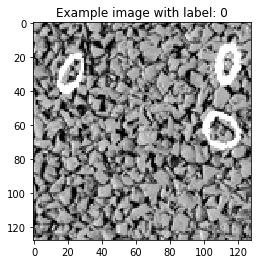

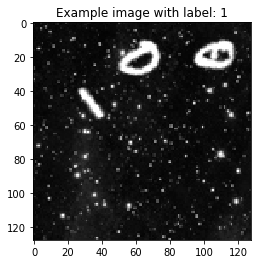

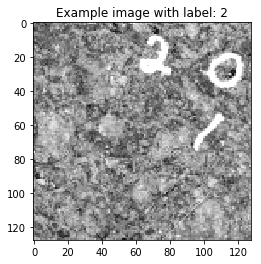

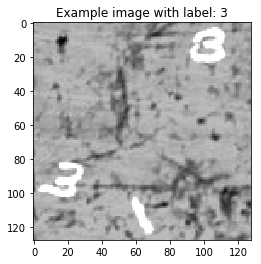

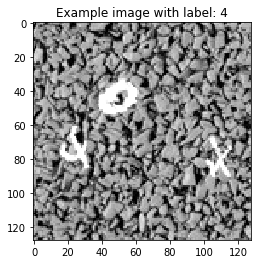

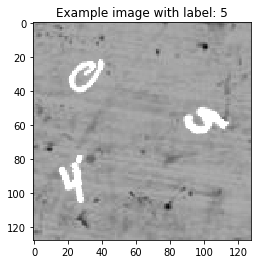

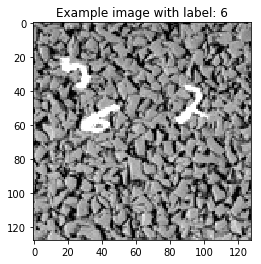

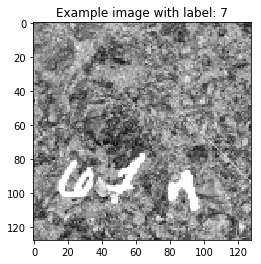

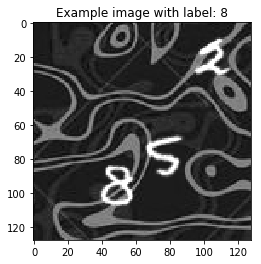

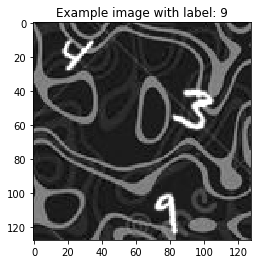

In [4]:
import os
import numpy as np
from src.util.fileio import load_pkl_file, load_training_labels, show_image
from src.config import data_path, training_images_file, training_labels_file_name

training_images_file_path = os.path.join(data_path, training_images_file)
training_labels_file_path = os.path.join(data_path, training_labels_file_name)
print("Loading images...")
training_images = load_pkl_file(training_images_file_path)
print("Loading labels...")
training_labels = load_training_labels(training_labels_file_path)

print("Calculating the proportions of the data")
unique, counts = np.unique(training_labels, return_counts=True)
counts = (counts / training_labels.shape[0]) * 100
for i in range(unique.shape[0]):
    print("Label:", unique[i], ", proportion:", round(counts[i], 2), "%")

n = int(0)
for i in range(training_images.shape[0]):
    if training_labels[i] == n:
        img_title = "Example image with label: " + str(n)
        show_image(training_images[i], title=img_title)
        n += 1

An interesting note here, is that the dataset is highly unbalanced, where unsurprisingly, there are far fewer images
where the largest number is zero compared to the other numbers (0.08% for 0 compared to 26.9% for 9).

## Classification strategy

An interesting strategy to take for this particular classification task is to reduce the problem to the basic MNIST
number classification task. To do this, we would need to extract all three numbers from each image and transform them into the
same format as a regular MNIST dataset digit. Let's see what the numbers from the MNIST dataset look like.


Loading MNIST dataset...
Calculating the proportions of the data
Label: 0 , proportion: 9.87 %
Label: 1 , proportion: 11.24 %
Label: 2 , proportion: 9.93 %
Label: 3 , proportion: 10.22 %
Label: 4 , proportion: 9.74 %
Label: 5 , proportion: 9.04 %
Label: 6 , proportion: 9.86 %
Label: 7 , proportion: 10.44 %
Label: 8 , proportion: 9.75 %
Label: 9 , proportion: 9.92 %


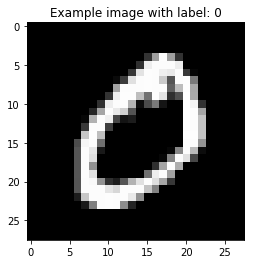

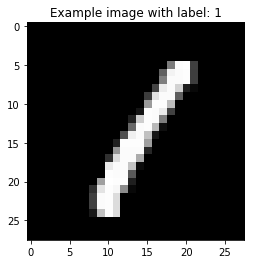

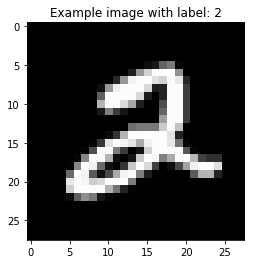

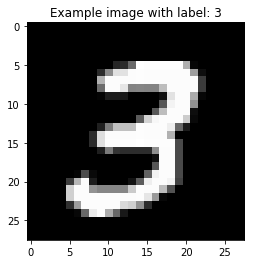

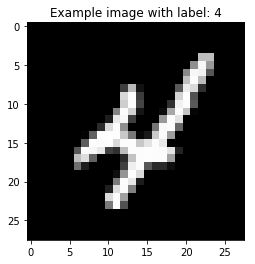

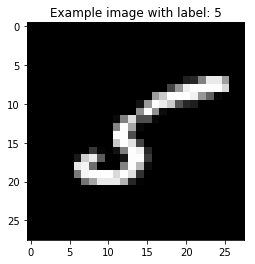

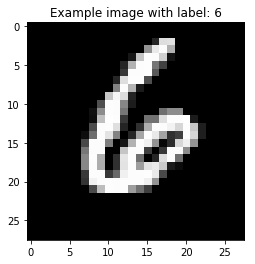

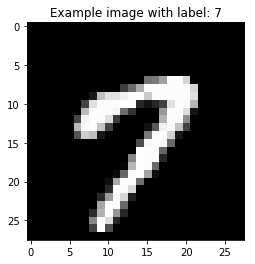

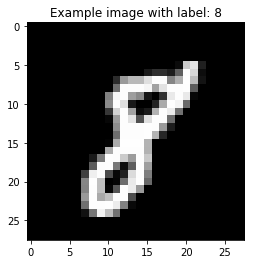

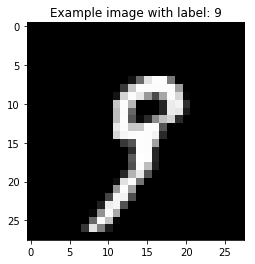

In [5]:
from keras.datasets import mnist

print("Loading MNIST dataset...")
(training_images_MNIST, training_labels_MNIST) = mnist.load_data()[0]

print("Calculating the proportions of the data")
unique, counts = np.unique(training_labels_MNIST, return_counts=True)
counts = (counts / training_labels_MNIST.shape[0]) * 100
for i in range(unique.shape[0]):
    print("Label:", unique[i], ", proportion:", round(counts[i], 2), "%")

n = int(0)
for i in range(training_images_MNIST.shape[0]):
    if training_labels_MNIST[i] == n:
        img_title = "Example image with label: " + str(n)
        show_image(training_images_MNIST[i], title=img_title)
        n += 1

The goal would be to reduce our modified dataset to look like the original MINST dataset to reduce the scope of the problem.
Once all three numbers are extracted from each image and transformed to look like samples from the MNIST dataset, we can predict
the label of each sub image and make an overall prediction with the subprediction with the largest magnitude.

As we can see, the background of each image introduces lots of noise and makes the
extraction task more difficult. The open CV library can be used here to threshold the pixels and 
remove the background as much as possible.

Once we threshold each image to remove the background, we need to find the three largest blobs of non zero pixels which
would (hopefully) correspond to our three numbers. Because some numbers such as 4 and 5 that are written in two pen strokes
could be composed of two disconnected components, the image is dilated to try to (hopefully) connect them if they are disconnected.

This could however, cause problems if two numbers are close to each other in the picture which leads them to connect when the
image is dilated. A fail safe was created sor this scenario to keep eroding the picture until at least 3 blobs are found.


Once the blobs corresponding to the three numbers are found, we can paste them onto canvases of size 28*28 to make them look like
pictures from the MNIST dataset.

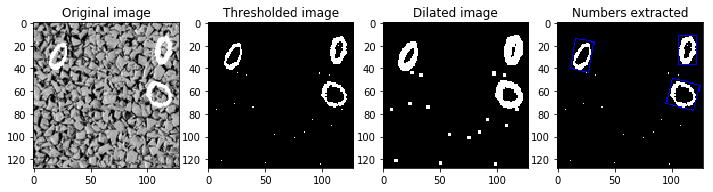

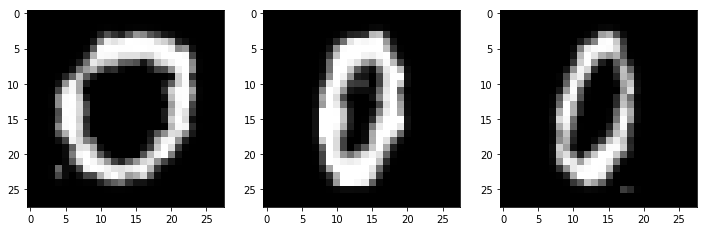

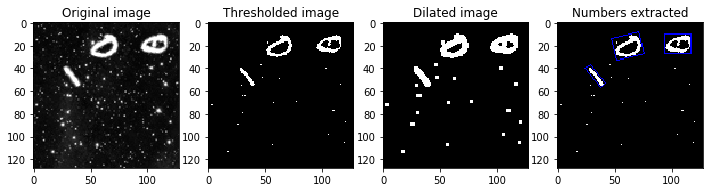

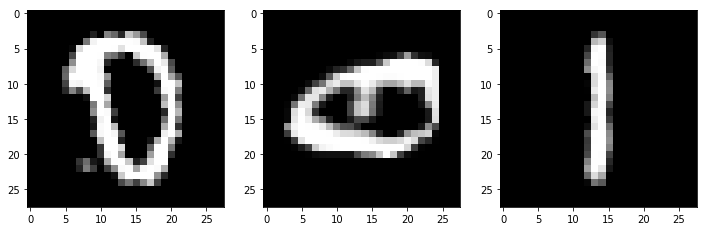

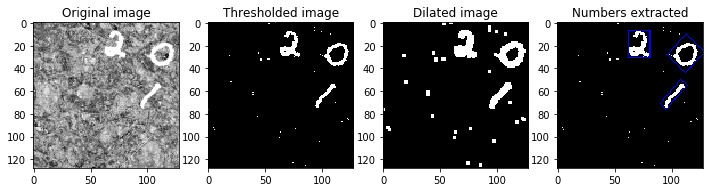

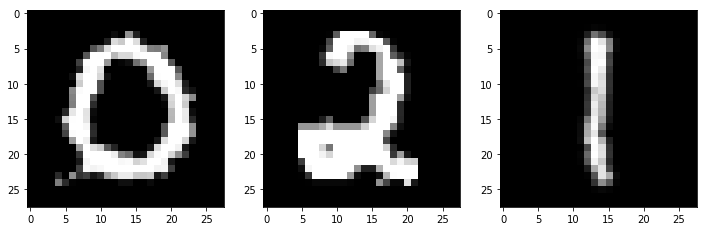

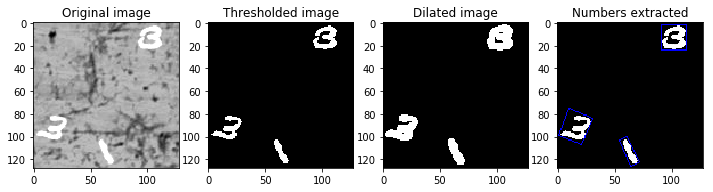

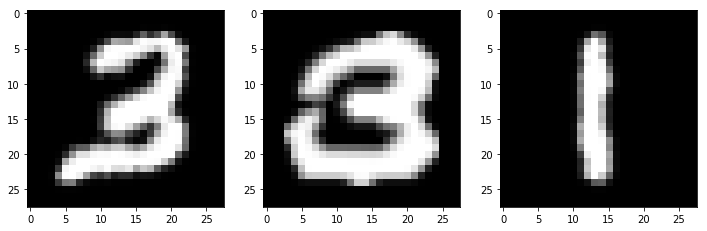

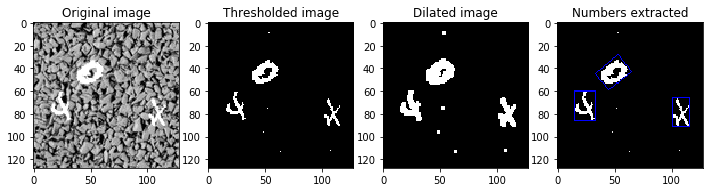

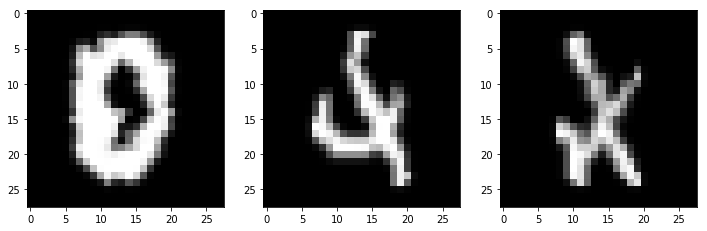

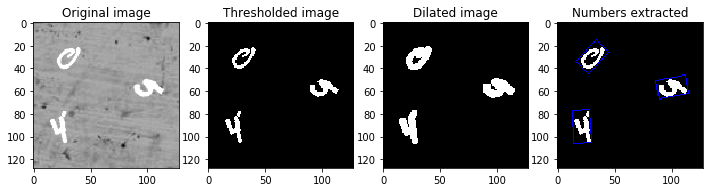

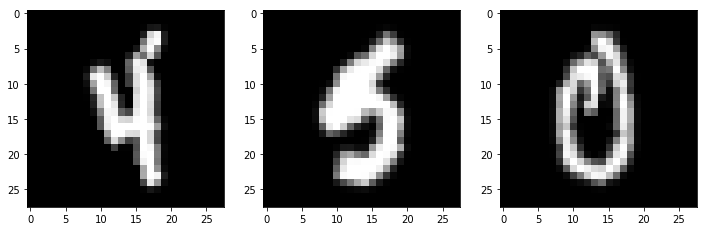

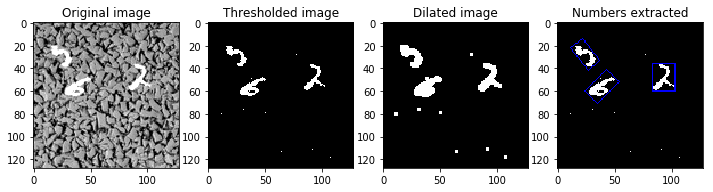

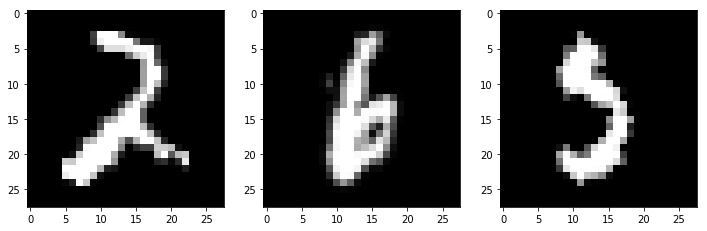

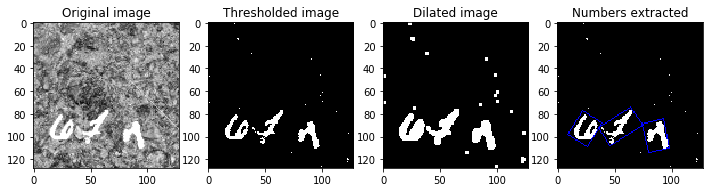

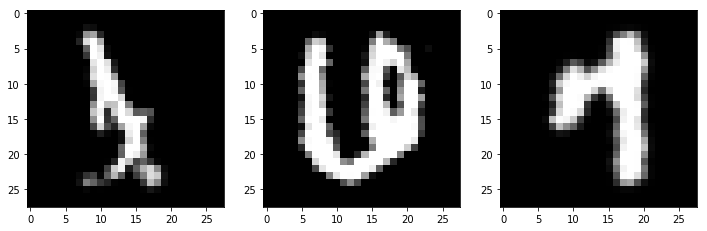

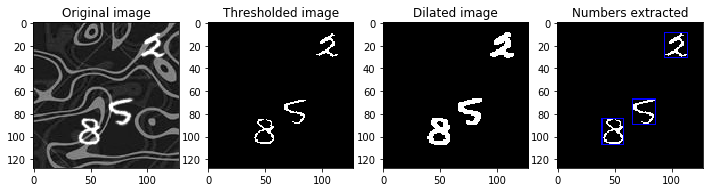

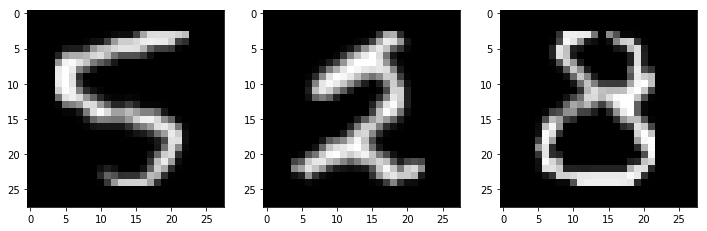

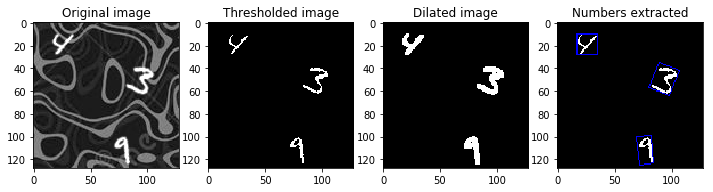

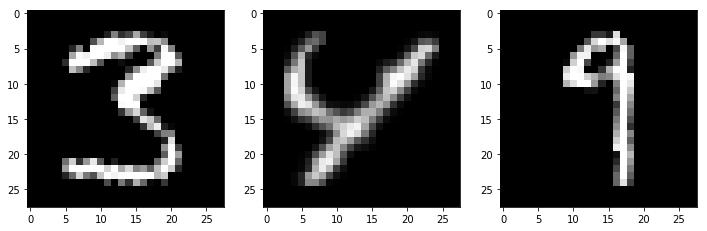

In [6]:
from src.data_processing.number_extraction import extract_k_numbers

n = int(0)
for i in range(training_images.shape[0]):
    if training_labels[i] == n:
        extract_k_numbers(training_images[i], show_images=True)
        n += 1


With this technique, we can almost always extract the three numbers in the images and transform them to match
the format of the regular MNIST classification problem. We can then train a classifier that trains directly on the MNIST
dataset. For each sample to be predicted, this technique is used to extract the three numbers in the image, then each number
is predicted individually using the model. The overall prediction will be the largest predicted label.